In [1]:
import datetime as dt
import os
import gc

import pandas as pd
# import dask.dataframe as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import KFold

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [3]:
INPUT_FOLDER = './data/input'
OUTPUT_FOLDER = './data/output'

In [4]:
os.listdir(INPUT_FOLDER)

['geo_params.csv',
 'sample_final.csv',
 'sku_final.csv',
 'test_data.csv',
 'train_final.csv']

## Зчитаємо дані

In [5]:
dateparser = lambda x: dt.datetime.strptime(x, '%Y-%m-%d')

In [6]:
df_train = pd.read_csv(os.path.join(INPUT_FOLDER, 'train_final.csv'), 
    index_col='ID', 
    parse_dates = ['date'],
    date_parser=dateparser)  

In [7]:
df_train['sales'].fillna(0, inplace=True)

In [8]:
df_train.sort_values('date', inplace=True)

In [9]:
df_train['price'] = df_train.groupby(['geoCluster', 'SKU'], sort=False)['price'].apply(lambda x: x.ffill().bfill())

In [14]:
df_test = pd.read_csv(
    os.path.join(INPUT_FOLDER, 'test_data.csv'),
    index_col='ID', 
    parse_dates = ['date'],
    date_parser=dateparser
)

In [20]:
df_train = df_train[df_train['date'] >= '2021-05-01']

In [21]:
submission = pd.read_csv(os.path.join(INPUT_FOLDER, 'sample_final.csv'), index_col='ID')

submission.head()

,sales
ID,
RR1666030,0
RR1666031,0
RR1666032,0
RR1666033,0
RR1666034,0


In [23]:
geo_params = pd.read_csv(os.path.join(INPUT_FOLDER, 'geo_params.csv'))
geo_params.head()

,geoCluster,cityId
0,21,1
1,47,1
2,48,1
3,92,1
4,112,1


In [26]:
sku = pd.read_csv(os.path.join(INPUT_FOLDER, 'sku_final.csv'))

sku.head()

,SKU,productCategoryId,productCategory_caption_UKR,productCategory_caption_RU,productCategory_caption_ENG,productTypeId,productType_caption_UKR,productType_caption_RU,productType_caption_ENG,brandId,lagerUnitQuantity,lagerUnitTypeId,lagerUnitType_caption,trademark,countryOfOrigin,countryOfOrigin_caption,commodity_group,commodity_group_caption_UKR,commodity_group_caption_RU,commodity_group_caption_ENG
0,17,5416.0,Хурма,Хурма,Persimmon,4770.0,Тропічні фрукти - Хурма - Звичайна,Тропические фрукты - Хурма - Обычная,Tropical fruit — Persimmon — Plain,NaN,1.0,1,г,NaN,NaN,NaN,5551018,Фрукти тропічні,Фрукты тропические,Tropical fruits
1,18,5413.0,Фейхоа,Фейхоа,Feijoa,4772.0,Тропічні фрукти - Екзотичні,Тропические фрукты - Экзотические,Tropical fruit — Exotic,NaN,1.0,1,г,NaN,NaN,NaN,5551018,Фрукти тропічні,Фрукты тропические,Tropical fruits
2,24,5425.0,Гранат,Гранат,Pomegranate,4760.0,Тропічні фрукти - Гранат - Звичайний,Тропические фрукты - Гранат - Обычный,Tropical fruit — Pomegranate— Plain,NaN,1.0,1,г,NaN,NaN,NaN,5551018,Фрукти тропічні,Фрукты тропические,Tropical fruits
3,25,5431.0,Апельсин,Апельсин,Orange,4773.0,Цитрусові фрукти - Апельсин - Звичайний,Цитрусовые фрукты - Апельсин - Обычный,Citrus fruit — Orange — Plain,NaN,1.0,2,кг,NaN,8.0,Іспанія,5551018,Фрукти тропічні,Фрукты тропические,Tropical fruits
4,208,5835.0,Вода України газована,Вода Украины газированная,"Water, Ukraine, sparkling",3457.0,Лікувально-столова вода - Україна - ПЕТ - від ...,Лечебно-столовая вода - Украина - ПЭТ - от 1л ...,Therapeutic-table water — Ukraine — PET — from...,1241.0,1.5,3,л,3670.0,1.0,Україна,5550022,Вода Мфнеральна,Вода Минеральная,Mineral water


# Data preprocessing

In [27]:
def merge_data(df):
    df = df.copy(deep=True)
    df = df.merge(sku, on = 'SKU', how='left')
    df = df.merge(geo_params, on = 'geoCluster', how='left')
    return df

def preprocess_date(df):
    df['month'] = df['date'].dt.month
#     df['weekofyear'] = df['date'].dt.weekofyear
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
#     df['dayofyear'] = df['date'].dt.dayofyear
    return df

In [28]:
df_train = merge_data(df_train)

In [29]:
df_train = preprocess_date(df_train)

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8514733 entries, 0 to 8514732
Data columns (total 28 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   geoCluster                   int64         
 1   SKU                          int64         
 2   date                         datetime64[ns]
 3   price                        float64       
 4   sales                        float64       
 5   productCategoryId            float64       
 6   productCategory_caption_UKR  object        
 7   productCategory_caption_RU   object        
 8   productCategory_caption_ENG  object        
 9   productTypeId                float64       
 10  productType_caption_UKR      object        
 11  productType_caption_RU       object        
 12  productType_caption_ENG      object        
 13  brandId                      float64       
 14  lagerUnitQuantity            float64       
 15  lagerUnitTypeId              int64         
 16  

In [31]:
# df_train.sample(15)

In [32]:
cat_cols = [
    'geoCluster', 'SKU', 'productCategoryId', 'productTypeId', 'brandId', 'lagerUnitTypeId', 
    'trademark', 'countryOfOrigin', 'commodity_group', 'cityId', 
    'month', 
#     'weekofyear',
    'day',
    'dayofweek',
#     'dayofyear'
]
num_cols = [
    'price', 
    'lagerUnitQuantity',
#     'price_change'

]
target = 'sales'
info_cols = ['date']
drop_cols = ['productCategory_caption_UKR', 'productCategory_caption_RU', 'productCategory_caption_ENG',
    'productType_caption_UKR', 'productType_caption_RU', 'productType_caption_ENG', 'lagerUnitType_caption', 'countryOfOrigin_caption',
    'commodity_group_caption_UKR', 'commodity_group_caption_RU', 'commodity_group_caption_ENG']

def categorize_columns(df):
    df = df.copy(deep=True)
    df.drop(drop_cols, axis=1, inplace=True)
    df[cat_cols] = df[cat_cols].astype('category')
    return df

In [33]:
df_train = categorize_columns(df_train)

In [34]:
X, y = df_train.drop(target, axis=1).copy(), df_train[target].copy()

In [35]:
del df_train
gc.collect()

57

In [36]:
sku_float_sales = X[y - y.astype(int) != 0]['SKU'].unique()

# Model training

In [37]:
params = {
    'random_state':42, 
    'n_estimators':500,
    'objective': 'regression',
    'metric': 'mae',
    "early_stopping_rounds":50,
    'learning_rate':0.1,
    'subsample':0.8,
    'subsample_freq':10,
    'feature_fraction':0.5    
}


In [38]:
def custom_mae(y_true, y_pred, dates):
    df = pd.DataFrame(data={
        'y_true': np.asarray(y_true), 
        'y_pred': np.asarray(y_pred), 
        'date': np.asarray(dates)})
    df['error'] = np.abs(df['y_pred'] - df['y_true'])
    df_sum = df.groupby('date').sum().reset_index()
    df_sum.dropna(subset=['error', 'y_true'], how='any', inplace=True)
    df_sum = df_sum[df_sum['y_true'] > 0]
    if df_sum.shape[0] != df['date'].drop_duplicates().shape[0]:
        print(f"{df['date'].drop_duplicates().shape[0] - df_sum.shape[0]} rows were dropped because of 0 sales")
    return (df_sum['error'] / df_sum['y_true']).mean()

In [39]:
n_splits = 5
folds = np.array_split(X['date'].drop_duplicates().values, n_splits)
folds = [(fold[0], fold[-1]) for fold in folds]
for i, fold in enumerate(folds):
    print(f'Fold {i}: {fold}')

Fold 0: (numpy.datetime64('2021-05-01T00:00:00.000000000'), numpy.datetime64('2021-05-16T00:00:00.000000000'))
Fold 1: (numpy.datetime64('2021-05-17T00:00:00.000000000'), numpy.datetime64('2021-06-01T00:00:00.000000000'))
Fold 2: (numpy.datetime64('2021-06-02T00:00:00.000000000'), numpy.datetime64('2021-06-17T00:00:00.000000000'))
Fold 3: (numpy.datetime64('2021-06-18T00:00:00.000000000'), numpy.datetime64('2021-07-03T00:00:00.000000000'))
Fold 4: (numpy.datetime64('2021-07-04T00:00:00.000000000'), numpy.datetime64('2021-07-19T00:00:00.000000000'))


In [40]:
models = []

train_mae_scores = []
val_mae_scores = []

In [41]:
for fold, fold_dates in enumerate(folds):
    
    print(f'\nFold {fold+1}')
    
    start_date, end_date = pd.Timestamp(fold_dates[0]), pd.Timestamp(fold_dates[1])
    print(start_date, end_date)
    
    train_mask = (X['date'] < start_date) | (X['date']>end_date)
    val_mask = (X['date'] >= start_date) & (X['date'] <= end_date)

    
    X_train, y_train = X.loc[train_mask], y.loc[train_mask]
    X_val, y_val = X.loc[val_mask], y.loc[val_mask]
    
    train_dates, val_dates = X_train['date'], X_val['date']
    
    X_train, X_val = X_train.drop('date', axis=1), X_val.drop('date', axis=1)
    
    lgb_reg = lgb.LGBMRegressor(**params)
    lgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=50)
    
    y_train_pred = lgb_reg.predict(X_train)
    y_val_pred = lgb_reg.predict(X_val)
    
#     y_train_pred = np.where(X_train['SKU'].isin(sku_float_sales), y_train_pred, np.round(y_train_pred))
#     y_val_pred = np.where(X_val['SKU'].isin(sku_float_sales), y_val_pred, np.round(y_val_pred))
    
    train_mae_scores.append(custom_mae(y_train, np.round(y_train_pred), train_dates))
    val_mae_scores.append(custom_mae(y_val, np.round(y_val_pred), val_dates))
    
    print('Train mean daily MAE:', train_mae_scores[-1])
    print('Valid mean daily MAE:', val_mae_scores[-1])
    
    models.append(lgb_reg)


Fold 1
2021-05-01 00:00:00 2021-05-16 00:00:00


/home/eddie/miniconda3/envs/hack4retail/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/home/eddie/miniconda3/envs/hack4retail/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/eddie/miniconda3/envs/hack4retail/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	training's l1: 0.286592	valid_1's l1: 0.291598
Train mean daily MAE: 1.0370767630681577
Valid mean daily MAE: 1.0568761683609842

Fold 2
2021-05-17 00:00:00 2021-06-01 00:00:00
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[50]	training's l1: 0.283891	valid_1's l1: 0.299177
[100]	training's l1: 0.281303	valid_1's l1: 0.299156
Train mean daily MAE: 1.0378611854219386
Valid mean daily MAE: 1.0314736089208234

Fold 3
2021-06-02 00:00:00 2021-06-17 00:00:00
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[50]	training's l1: 0.289658	valid_1's l1: 0.282616
[100]	training'

In [42]:
train_mae_scores, val_mae_scores = np.array(train_mae_scores), np.array(val_mae_scores)

print(f'Train score: {train_mae_scores.mean()}+-{train_mae_scores.std()}\n{train_mae_scores}\n')
print(f'Val score: {val_mae_scores.mean()}+-{val_mae_scores.std()}\n{val_mae_scores}\n')

Train score: 1.0323963929132929+-0.00606872006386897
[1.03707676 1.03786119 1.02118474 1.03467709 1.03118219]

Val score: 1.062826087054429+-0.024141512059155802
[1.05687617 1.03147361 1.04552818 1.08285062 1.09740186]



In [61]:
pd.Series(index=X_train.columns, data=lgb_reg.feature_importances_).sort_values()

lagerUnitTypeId         5
commodity_group         7
countryOfOrigin        15
cityId                 22
brandId                99
dayofweek             179
lagerUnitQuantity     185
trademark             220
month                 290
productCategoryId     297
productTypeId         315
day                   703
price                 867
geoCluster           1371
SKU                  1455
dtype: int32

In [45]:
X_train.columns

Index(['geoCluster', 'SKU', 'price', 'productCategoryId', 'productTypeId',
       'brandId', 'lagerUnitQuantity', 'lagerUnitTypeId', 'trademark',
       'countryOfOrigin', 'commodity_group', 'cityId', 'month', 'day',
       'dayofweek'],
      dtype='object')

In [46]:
gc.collect()

14

## Прогноз

In [47]:
df_test = merge_data(df_test)
df_test = preprocess_date(df_test)
df_test = categorize_columns(df_test)

In [48]:
X_sku_prices = X.groupby(['SKU'])['price'].agg(['min', 'max'])

In [49]:
def adjust_price(price, sku):
    price_min_max = X_sku_prices.loc[sku]
    if price > price_min_max['max']:
        return price_min_max['max']
    if price < price_min_max['min']:
        return price_min_max['min']
    return price

train_skus = X_sku_prices.index.tolist()
df_test.loc[df_test['SKU'].isin(train_skus), 'price'] = df_test.loc[df_test['SKU'].isin(train_skus)].apply(lambda row: adjust_price(row['price'], row['SKU']), axis=1)

In [50]:
df_test.drop(info_cols, axis=1, inplace=True)

In [51]:
predictions = []
for model in models:
    predictions.append(model.predict(df_test, num_iteration=lgb_reg.best_iteration_))

<AxesSubplot:>

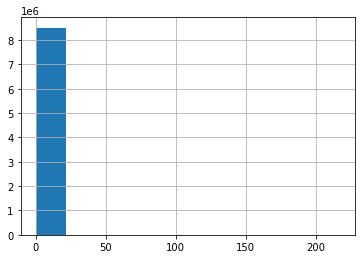

In [52]:
y.hist()

<AxesSubplot:>

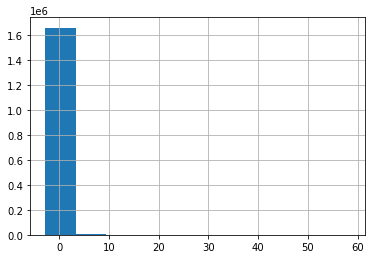

In [53]:
submission['sales'] = np.array(predictions).mean(axis=0)
submission['sales'].hist()

In [54]:
submission['sales'].min()

-2.7819200747371204

<AxesSubplot:>

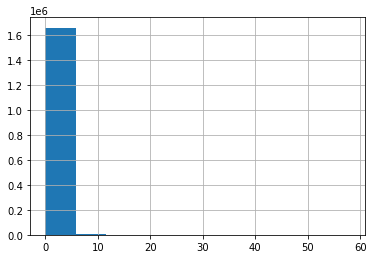

In [55]:
submission.loc[submission['sales']<0, 'sales'] = 0

submission['sales'] = np.round(submission['sales'])

submission['sales'].hist()

In [57]:
ts = dt.datetime.now().strftime('%Y%m%d_%H_%M_%S')
submission.to_csv(
    os.path.join(
        OUTPUT_FOLDER,
        f'{ts}.csv'
    )
)